In [48]:
import pandas as pd
import numpy as np
import os
import scipy.stats as stats

# train test split and modeling modules from sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#importing my acquire script
import acquire
import prepare
import explore

# Viz imports
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [94]:
# reading in telco churn data using function in acquire module
telco_df = acquire.get_telco_data()

In [97]:
# # describes the df, object and numeric cols
# acquire.get_data_summary(telco_df)

# # shows distribution of individual variables
# acquire.get_viz(telco_df)

telco_df.loc[5642]

payment_type_id                                   4
internet_service_type_id                          3
contract_type_id                                  3
customer_id                              1982-FEBTD
gender                                       Female
senior_citizen                                    0
partner                                         Yes
dependents                                      Yes
tenure                                           23
phone_service                                   Yes
multiple_lines                                  Yes
online_security                 No internet service
online_backup                   No internet service
device_protection               No internet service
tech_support                    No internet service
streaming_tv                    No internet service
streaming_movies                No internet service
paperless_billing                               Yes
monthly_charges                                25.6
total_charge

### Acquire Takeaways:
- Churn is our target variable
- payment_type_id == payment type. We will keep the payment type id column since that is numeric
- We will encode payment type to show the different payment types as numeric
- internet_service type id column is the same as internet service type column. We will keep the internet service type id column since that is numeric
- contract type id column is the same as contract type column. We will keep the contract type id column since that is numeric  and encode the contract type column to check for each contract category
- binary categorical columns like gender, partner, dependents will have to be encoded to be numeric
- total charges column has an object dtype - will have to change to float
- we will drop the customer id column 
- Some customers had no total charges -  this was where the tenure was 0 so must be new customers

# Prepare

In [51]:
telco_df = prepare.prep_telco_data(telco_df)
#telco_df.head()

There are no duplicate rows in your dataset.
Removing the following columns: ['customer_id']


In [6]:
telco_df.churn_Yes.shape

(7043,)

In [52]:
train, validate, test = prepare.train_validate_test_split(telco_df, 'churn_Yes')

In [53]:
# check number of rows and columns in the three data splits
train.shape, validate.shape, test.shape

((3943, 34), (1691, 34), (1409, 34))

### Prepare Takeaways:

- There are no duplicates in the dataset
- I dropped the customer id column 
- I changed the total charges which were empty to null values and then replaced them with the same value as the monthly charges for new customers.
- Then I changed total charges to a float
- Encoded categorical variables
- Split the data set into train, validate and test

# Explore

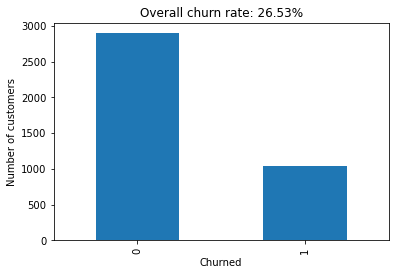

In [9]:
train.churn_Yes.value_counts().sort_index().plot.bar()
churn_rate = train.churn_Yes.mean()
plt.title(f'Overall churn rate: {churn_rate:.2%}')
plt.xlabel('Churned')
plt.ylabel('Number of customers')
plt.show()

### Takeaways:
   
   - Overall churn rate is not very high
   - However, we want to explore ways to reduce churn so we can increase customer retention

In [10]:
# setting rc parameters for visualizations
plt.rc('font', size=14)
plt.rc('figure', figsize=(14, 10))

#### quick look at the training dataset

In [93]:
train.head()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,has_partner,has_dependents,has_phone_service,has_single_line,has_multiple_lines,online_security_No internet service,has_online_security,online_backup_No internet service,has_online_backup,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,has_1yr_contract,has_2yr_contract,has_fiber,has_internet_service,pay_by_card,pay_echeck,pay_mailcheck
5642,4,3,3,0,23,25.60,514.75,0,1,1,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0
3338,3,2,2,0,27,100.50,2673.45,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0
4273,1,2,1,1,7,89.15,574.35,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0
2382,3,1,1,0,47,58.60,2723.40,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2655,4,2,3,0,41,99.65,4220.35,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,1,0,0


## Exploring Churn Rate by features

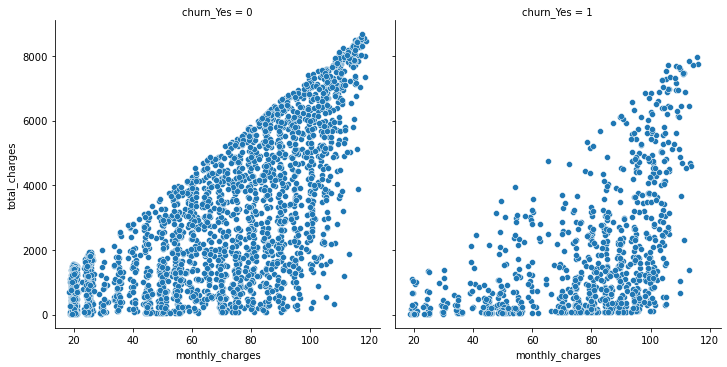

In [36]:
# %%time
# Create a stripplot to examine the distribution of species throughout each continuous variable.
# sns.stripplot(data=train, x='monthly_charges', y='churn_Yes', hue='pay_echeck')
sns.relplot(x='monthly_charges', y='', col='churn_Yes', data=train)
# plt.title('petal_length and petal_width show clear distinctions in measurements by species')

plt.show()

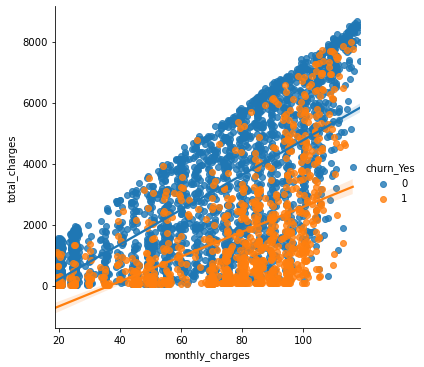

In [43]:
sns.lmplot(x='monthly_charges', y='total_charges', hue='churn_Yes', data=train)


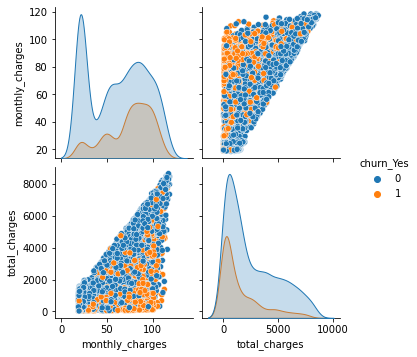

In [42]:
# higher monthly charges for customers who churned
sns.pairplot(train,vars=['monthly_charges', 'total_charges'], hue = 'churn_Yes')

In [30]:
features = ['pay_by_card', 'pay_echeck', 'pay_mailcheck',
            'has_1yr_contract', 'has_2yr_contract', 'has_fiber']

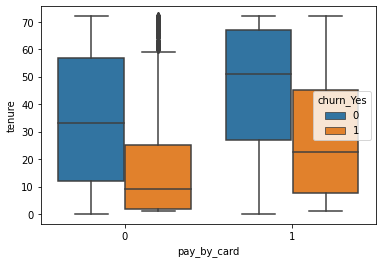

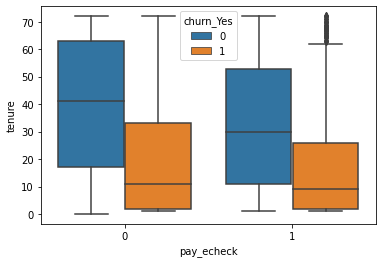

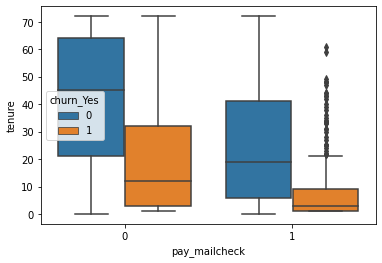

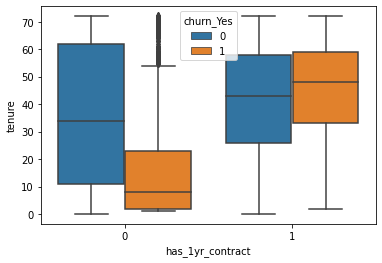

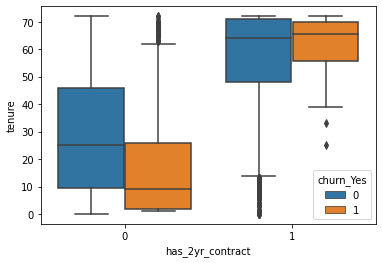

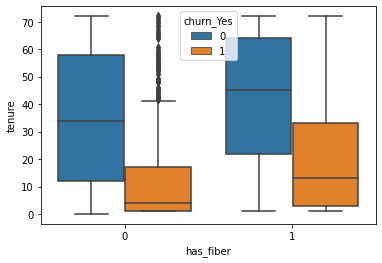

<Figure size 432x288 with 0 Axes>

In [31]:
for x in features:
    plt.show(sns.boxplot(data = telco_df, x = telco_df[x], y = 'tenure', hue = 'churn_Yes'))
    plt.tight_layout()
    

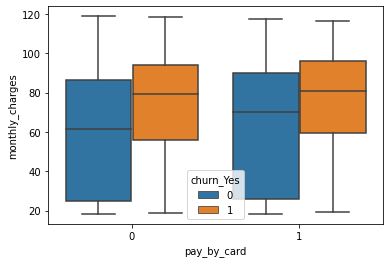

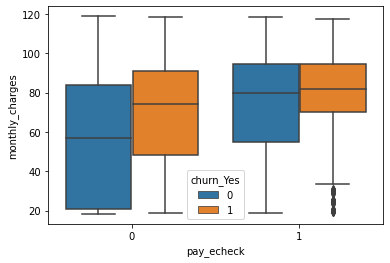

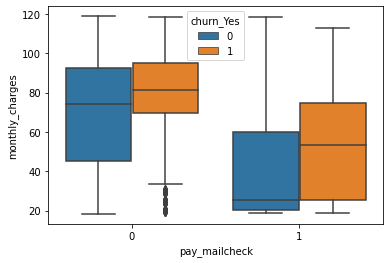

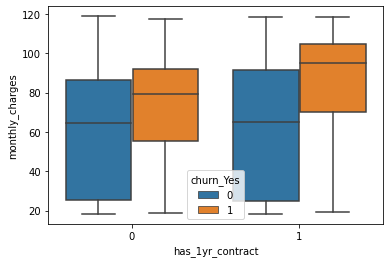

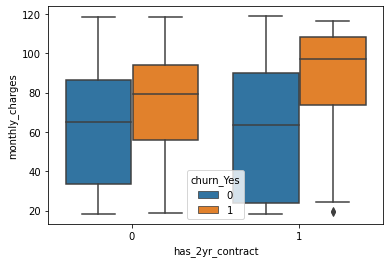

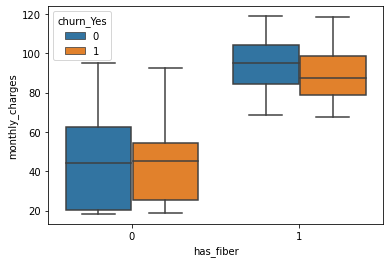

<Figure size 432x288 with 0 Axes>

In [29]:
# multivariate exploration
for x in features:
    plt.show(sns.boxplot(data = telco_df, x = telco_df[x], y = 'monthly_charges', hue = 'churn_Yes'))
    plt.tight_layout()
    

Takeaways:
- Median monthly charges the highest for 1 yr contract customers who churned
- Median monthly charges the highest for 2 yr contract customers who churned
- monthly charges alot higher for customers with fiber internet
    - their minimum is higher than the 75th percentile of customers without fiber internet
- customers who paid by monthly check had lower monthly charges than those who did 
    - fewer customers who did not pay by check churned
    - some outliers in monthly charges for churning customers who didn't pay by check
    - if I had more time, I would like to further investigate these outliers 

In [ ]:
cat_vars = ['gender_Male', 'senior_citizen']
quant_vars = ['monthly_charges']

In [ ]:
explore.explore_univariate(train, cat_vars, quant_vars)

In [ ]:
cat_vars = ['gender_Male', 'senior_citizen']
quant_vars = ['monthly_charges']
explore.explore_bivariate(train, 'churn_Yes', cat_vars, quant_vars, alternative_h='two-sided' )

In [ ]:
train.columns

In [ ]:
telco_df.contract_type_id.value_counts()

In [ ]:
cat_vars = ['contract_type_id', 'has_1yr_contract']
quant_vars = ['total_charges', 'monthly_charges']
explore.explore_bivariate(train, 'churn_Yes', cat_vars, quant_vars, alternative_h='two-sided' )

In [ ]:
cat_vars = ['pay_by_card', 'pay_echeck', 'pay_mailcheck', 'payment_type_id']
quant_vars = []
explore.explore_bivariate(train, 'churn_Yes', cat_vars, quant_vars, alternative_h='two-sided' )

In [ ]:
cat_vars = ['has_phone_service', 'has_internet_service']
quant_vars = []
explore.explore_bivariate(train, 'churn_Yes', cat_vars, quant_vars, alternative_h='two-sided' )

In [ ]:
cat_vars = ['has_2yr_contract', 'has_1yr_contract']
quant_vars = ['monthly_charges']
explore.explore_bivariate(train, 'churn_Yes', cat_vars, quant_vars, alternative_h='two-sided' )

In [ ]:
train.churn_Yes.value_counts().sort_index().plot.bar()
churn_rate = train.churn_Yes.mean()
plt.title(f'Overall churn rate: {churn_rate:.2%}')
plt.xlabel('Churned')
plt.ylabel('Number of customers')
plt.show()


Hypothesis:
    
h_null = churn rate is not dependent on internet service

h_alt = churn rate is dependent on internet service

In [ ]:
alpha = 0.05

In [ ]:
ct = pd.crosstab(train.has_internet_service, train.churn_Yes)
ct

In [ ]:
chi2_stat, p, degf, expected_internet = stats.chi2_contingency(ct)
print(expected_internet)
print(f"p-val: {p}")

In [ ]:
if p < alpha:
    print("We reject the null hypothesis. We have evidence to believe that churn rate is dependent on internet service.")
else:
    print("We fail to reject the null hypothesis. We have evidence to believe that churn rate is not dependent on internet service.")


Hypothesis:
h_null = no correlation between total charges and contract type 

h_alt = There is a correlation between total charges and contract type

In [ ]:
n = train.shape[0]     # number of observations in the train dataset
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
alpha = 1 - conf_interval

In [ ]:
corr, p = stats.pearsonr(train.total_charges, train.contract_type_id)
corr, p

In [ ]:
if p < alpha:
    print("We reject the null hypothesis. There is a correlation between monthly charges and contract type.")
else:
    print("We fail to reject the null hypothesis. There is no correlation between monthly charges and contract type.")

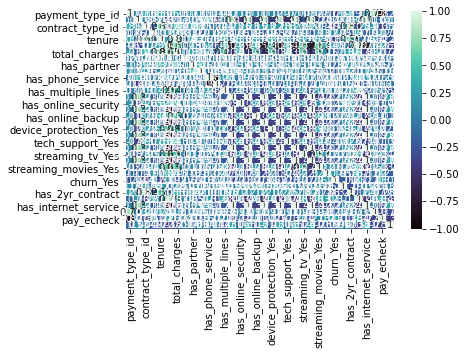

In [34]:
sns.heatmap(train.corr(), cmap='mako', annot=True)
plt.show()

## Model 

Because I am trying to predict the customers that will churn, the positive variable will be churn = 1 in my models.

Possible Outcomes:

TP: Predict that a customer will churn and they do
TN: Predict that a customer will not churn and they do not
FP: Predict that a customer will churn but they do not
FN: Predict that a customer will not churn but they do
I am trying to identify customers that will churn so I want to minimize false negatives. Accuracy will be the primary measure for selecting a top model, followed by recall.

### Setup the Baseline

The baseline was set to be the most frequently occurring value in the training split. The baseline was set to be no churn or 0 in the churn column. The baseline accuracy was found to be 73.47%.

In [9]:
# finding the most common value for the target variable in the training split
train.churn_Yes.value_counts()

0    2897
1    1046
Name: churn_Yes, dtype: int64

In [10]:
# setting the baseline equal to no churn
train['baseline'] = 0 

In [14]:
# calculating the baseline accuracy to compare our models to 
baseline_accuracy = (train.churn_Yes == train.baseline).mean()
print(f'The baseline accuracy is {baseline_accuracy:.2%}')

The baseline accuracy is 73.47%


In [16]:
# drop the baseline column from train df
train.drop(columns='baseline', inplace=True)

## Decision Tree Model

Model 1
- Create a model using 'has_internet_service', 'contract_type_id', 'monthly_charges', 'pay_by_card','pay_echeck',
           'payment_type_id','online_backup_No internet service','internet_service_type_id',
           'tenure'
- Check if the model beats the baseline

In [54]:
# split our X and y
X_train = train.drop(columns='churn_Yes')
y_train = train[['churn_Yes']]

In [55]:
# specify the features being used
features = ['has_internet_service', 'contract_type_id', 'monthly_charges', 'pay_by_card','pay_echeck',
           'payment_type_id','online_backup_No internet service','internet_service_type_id',
           'tenure']

In [58]:
# 1. Create the model
clf1 = DecisionTreeClassifier(max_depth=3, random_state=123)

In [59]:
# 2. fit the model 
clf1.fit(X_train[features], y_train)

DecisionTreeClassifier(max_depth=3, random_state=123)

In [60]:
# 3. Make predictions using the same features
y_pred = clf1.predict(X_train[features])

In [61]:
accuracy = clf1.score(X_train[features], y_train)

# create the confusion matrix
conf = confusion_matrix(y_train, y_pred)

# creating the classification report and transposing it
class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
conf = confusion_matrix(y_train, y_pred)

# true positive rate
tpr = conf[1][1] / conf[1].sum()

# false positive rate
fpr = conf[0][1] / conf[0].sum()

# true negative rate
tnr = conf[0][0] / conf[0].sum()

# false negative rate
fnr = conf[1][0] / conf[1].sum()

print(f'''
The accuracy for our model is {accuracy:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.7865
The True Positive Rate is 0.296, The False Positive Rate is 0.0366,
The True Negative Rate is 0.963, and the False Negative Rate is 0.704



,precision,recall,f1-score,support
0,0.791324,0.963410,0.868929,2897.000000
1,0.745192,0.296367,0.424077,1046.000000
accuracy,0.786457,0.786457,0.786457,0.786457
macro avg,0.768258,0.629889,0.646503,3943.000000
weighted avg,0.779086,0.786457,0.750918,3943.000000


Model 1 had a higher overall accuracy of 79% on in sample data comapred to the baseline of 73%. However, it had a high false negative rate and therefore, a low recall score of 30%.

## Random Forest Model

Model 2
- Create a model using 'has_internet_service', 'contract_type_id', 'monthly_charges', 'pay_by_card','pay_echeck',
           'payment_type_id','online_backup_No internet service','internet_service_type_id',
           'tenure'
- Check if the model beats the baseline

In [86]:
# Create the model
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=30, 
                            random_state=123)

In [87]:
# fit model to training data
rf.fit(X_train[features], y_train)

RandomForestClassifier(max_depth=30, random_state=123)

In [88]:
# 3. Make predictions using the same features
y_pred2 = rf.predict(X_train[features])

In [89]:
accuracy = rf.score(X_train[features], y_train)

# create the confusion matrix
conf = confusion_matrix(y_train, y_pred2)

# creating the classification report and transposing it
class_report = pd.DataFrame(classification_report(y_train, y_pred2, output_dict=True)).T
conf = confusion_matrix(y_train, y_pred2)

# true positive rate
tpr = conf[1][1] / conf[1].sum()

# false positive rate
fpr = conf[0][1] / conf[0].sum()

# true negative rate
tnr = conf[0][0] / conf[0].sum()

# false negative rate
fnr = conf[1][0] / conf[1].sum()

print(f'''
The accuracy for our model is {accuracy:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.9937
The True Positive Rate is 0.988, The False Positive Rate is 0.00414,
The True Negative Rate is 0.996, and the False Negative Rate is 0.0124



,precision,recall,f1-score,support
0,0.995514,0.995858,0.995686,2897.00000
1,0.988517,0.987572,0.988044,1046.00000
accuracy,0.993660,0.993660,0.993660,0.99366
macro avg,0.992015,0.991715,0.991865,3943.00000
weighted avg,0.993658,0.993660,0.993659,3943.00000


Model 2 has a higher overall accuracy of 88% compared to model 1 (79%); this also beats the baseline
accuracy of 73%. The false negative rate is low at 29% and the recall score of 71%  is higher than that of model 1.

# KNN Model

Model 3
- Create a model using 'has_internet_service', 'contract_type_id', 'monthly_charges', 'pay_by_card','pay_echeck',
     'payment_type_id','online_backup_No internet service','internet_service_type_id',
     'tenure'
- Check if the model beats the baseline

In [46]:
# Create the model
knn = KNeighborsClassifier(n_neighbors=4)


In [56]:
# fit the model
knn.fit(X_train[features], y_train)


KNeighborsClassifier(n_neighbors=4)

In [58]:
# make predictions using the model
y_pred3 = knn.predict(X_train[features])

In [60]:
accuracy = knn.score(X_train[features], y_train)

# create the confusion matrix
conf = confusion_matrix(y_train, y_pred3)

# creating the classification report and transposing it
class_report = pd.DataFrame(classification_report(y_train, y_pred3, output_dict=True)).T
conf = confusion_matrix(y_train, y_pred3)

# true positive rate
tpr = conf[1][1] / conf[1].sum()

# false positive rate
fpr = conf[0][1] / conf[0].sum()

# true negative rate
tnr = conf[0][0] / conf[0].sum()

# false negative rate
fnr = conf[1][0] / conf[1].sum()

print(f'''
The accuracy for our model is {accuracy:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8331
The True Positive Rate is 0.48, The False Positive Rate is 0.0394,
The True Negative Rate is 0.961, and the False Negative Rate is 0.52



,precision,recall,f1-score,support
0,0.836489,0.960649,0.894280,2897.000000
1,0.814935,0.479924,0.604091,1046.000000
accuracy,0.833122,0.833122,0.833122,0.833122
macro avg,0.825712,0.720286,0.749186,3943.000000
weighted avg,0.830771,0.833122,0.817299,3943.000000


Model 3 has an overall accuracy of 83% which is lower than Model 2 (88%) but higher than model 1 (79%); this also beats the baseline accuracy of 73%. The false negative rate is more than 50% and the recall score is about 48%. This is also lower than model 2 but higher than model 1.

# Logistic Regression 

- Create a model using 'has_internet_service', 'contract_type_id', 'monthly_charges', 'pay_by_card','pay_echeck', 'payment_type_id','online_backup_No internet service','internet_service_type_id', 'tenure'
- Check if the model beats the baseline

In [62]:
# create the model
logit = LogisticRegression(C=1, class_weight=None, 
                            random_state=123)

In [63]:
# fit the model 
logit.fit(X_train[features], y_train)

LogisticRegression(C=1, random_state=123)

In [64]:
# make predictions
y_pred4 = logit.predict(X_train[features])

In [65]:
accuracy = logit.score(X_train[features], y_train)

# create the confusion matrix
conf = confusion_matrix(y_train, y_pred4)

# creating the classification report and transposing it
class_report = pd.DataFrame(classification_report(y_train, y_pred4, output_dict=True)).T
conf = confusion_matrix(y_train, y_pred4)

# true positive rate
tpr = conf[1][1] / conf[1].sum()

# false positive rate
fpr = conf[0][1] / conf[0].sum()

# true negative rate
tnr = conf[0][0] / conf[0].sum()

# false negative rate
fnr = conf[1][0] / conf[1].sum()

print(f'''
The accuracy for our model is {accuracy:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.7925
The True Positive Rate is 0.494, The False Positive Rate is 0.0998,
The True Negative Rate is 0.9, and the False Negative Rate is 0.506



,precision,recall,f1-score,support
0,0.831368,0.900242,0.864435,2897.000000
1,0.641439,0.494264,0.558315,1046.000000
accuracy,0.792544,0.792544,0.792544,0.792544
macro avg,0.736403,0.697253,0.711375,3943.000000
weighted avg,0.780983,0.792544,0.783227,3943.000000


Model 4 has an overall accuracy of 79% which is the same as model 1. This model, like all the other models, also beats our baseline of 73%. Model 1 has a recall score of 49% which is a lot lower than Model 2 but only slightly higher than Model 3.

Based on the models created so far, Model 2 utilizing random forest seems to be the best one with the highest overall accuracy as well as recall score.

In [76]:
# Create the model
rf2 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

# fit model to training data
rf.fit(X_train[features], y_train)

# 3. Make predictions using the same features
y_pred5 = rf.predict(X_train[features])

In [77]:
accuracy = knn.score(X_train[features], y_train)

# create the confusion matrix
conf = confusion_matrix(y_train, y_pred5)

# creating the classification report and transposing it
class_report = pd.DataFrame(classification_report(y_train, y_pred5, output_dict=True)).T
conf = confusion_matrix(y_train, y_pred5)

# true positive rate
tpr = conf[1][1] / conf[1].sum()

# false positive rate
fpr = conf[0][1] / conf[0].sum()

# true negative rate
tnr = conf[0][0] / conf[0].sum()

# false negative rate
fnr = conf[1][0] / conf[1].sum()

print(f'''
The accuracy for our model is {accuracy:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8331
The True Positive Rate is 0.714, The False Positive Rate is 0.0621,
The True Negative Rate is 0.938, and the False Negative Rate is 0.286



,precision,recall,f1-score,support
0,0.900862,0.937867,0.918992,2897.000000
1,0.805825,0.714149,0.757223,1046.000000
accuracy,0.878519,0.878519,0.878519,0.878519
macro avg,0.853344,0.826008,0.838107,3943.000000
weighted avg,0.875651,0.878519,0.876078,3943.000000


## Validation 

Testing the best performing model i.e Model 2 random forest on out of sample data.

In [78]:
# split our X and y for the validate dataset
X_validate = validate.drop(columns='churn_Yes')
y_validate = validate[['churn_Yes']]


In [79]:
# assign features being used (same as the ones in training dataset)
features = ['has_internet_service', 'contract_type_id', 'monthly_charges', 'pay_by_card','pay_echeck',
           'payment_type_id','online_backup_No internet service','internet_service_type_id',
           'tenure']

In [90]:
y_pred_val = rf.predict(X_validate[features])

In [91]:
#classification report
print(classification_report(y_validate, y_pred_val))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1242
           1       0.56      0.47      0.51       449

    accuracy                           0.76      1691
   macro avg       0.69      0.67      0.68      1691
weighted avg       0.75      0.76      0.75      1691



This model does not perform as well on out of sample data. Overall accuracy reduced to 79% and recall score to 50%

Let's try out of sample performance on the next best performing model which was model 3 using the knn algorithm

In [84]:
y_pred_val2 = knn.predict(X_validate[features])

In [85]:
#classification report
print(classification_report(y_validate, y_pred_val2))

              precision    recall  f1-score   support

           0       0.80      0.92      0.85      1242
           1       0.62      0.35      0.45       449

    accuracy                           0.77      1691
   macro avg       0.71      0.64      0.65      1691
weighted avg       0.75      0.77      0.75      1691



The overall accuracy and recall scores are not dropping as much as model 4 in out of sample data for model 3 which leads me to conclude that Model 2 might be overfit and Model 3 might be the better model.